# Introduction

In this notebook, we'll implement simple RNNs and LSTMs, then explore how gradients flow through these different networks.

This notebook does not require a Colab GPU. If it's enabled, you can turn it off through Runtime -> Change runtime type. (This will make it more likely for you to get Colab GPU access later in the REAL_RNN_LSTM.ipynb problem.)

# Imports

Note: the ipympl installation will require you to restart the colab runtime.

In [1]:
! pip install ipympl

In [2]:
import copy

# If you are not using colab you can delete these two lines
#from google.colab import output
#output.enable_custom_widget_manager()

import torch as th
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets, Layout

In [3]:
%matplotlib ipympl

# 1.A: implementing a RNN layer

Consider using Pytorch's [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear). You can implement this with either one Linear layer or two. If you use two, remember that you only need to include a bias term for one of the linear layers.

In [4]:
class RNNLayer(nn.Module):
  def __init__(self, input_size, hidden_size, nonlinearity=th.tanh):
    """
    Initialize a single RNN layer.
    
    Inputs:
    - input_size: Data input feature dimension
    - hidden_size: RNN hidden state size (also the output feature dimension)
    - nonlinearity: Nonlinearity applied to the rnn output
    """
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.nonlinearity = nonlinearity
    ##############################################################################
    # TODO: Initialize any parameters your class needs.                          #
    ##############################################################################
    self.Wxh = nn.Parameter(th.randn(input_size, hidden_size))
    # Hidden-to-hidden weights
    self.Whh = nn.Parameter(th.randn(hidden_size, hidden_size))
    # Bias term
    self.bh = nn.Parameter(th.randn(hidden_size))
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def forward(self, x):
    """
    RNN forward pass
    
    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
             produced for each timestep
    - last_h: hidden state from the last timestep (B, hidden_size)
    """
    h_list = []  # List to store the hidden states [h_1, ... h_T]
    ##############################################################################
    # TODO: Implement the RNN forward step                                       #
    # 1. Initialize h0 with zeros                                                #
    # 2. Roll out the RNN over the sequence, storing hidden states in h_list     #
    # 3. Return the appropriate outputs                                          #
    ##############################################################################
    # Get batch size and sequence length
    B, seq_len, _ = x.shape
    
    # 1. Initialize h0 with zeros
    h_prev = th.zeros(B, self.hidden_size, device=x.device)
    
    # 2. Roll out the RNN over the sequence
    for t in range(seq_len):
        # Get input at current timestep
        x_t = x[:, t, :]
        
        # Compute next hidden state
        h_next = self.nonlinearity(x_t @ self.Wxh + h_prev @ self.Whh + self.bh)
        
        # Store the hidden state
        h_list.append(h_next)
        
        # Update h_prev for next timestep
        h_prev = h_next
    
    # 3. Set last_h to the last hidden state
    last_h = h_prev

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    # h_list should now contain all hidden states, each of size (B, hidden_size)
    # We will store the hidden states so we can analyze their gradients later
    self.store_h_for_grad(h_list)
    all_h = th.stack(h_list, dim=1)
    return all_h, last_h
  
  def store_h_for_grad(self, h_list):
    """
    Store input list and allow gradient computation for all list elements
    """
    for h in h_list:
      h.retain_grad()
    self.h_list = h_list


### Test Cases

If your implementation is correct, you should expect to see errors of less than 1e-4.

In [5]:
rnn = RNNLayer(1, 1)
# Overwrite initial parameters with fixed values.
# Should give deterministic results even with different implementations.
rnn.load_state_dict({k: v * 0 + .1 for k, v in rnn.state_dict().items()})
data = th.ones((1, 1, 1))
expected_out = th.FloatTensor([[[0.1973753273487091]]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_out.shape
assert th.all(th.isclose(all_h, last_h))
print(f'Expected: {expected_out.item()}, got: {last_h.item()}, max error: {th.max(th.abs(expected_out - last_h)).item()}')

rnn = RNNLayer(2, 3, nonlinearity=lambda x: x)  # no nonlinearity

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 18, f'expected 18 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_all_h = th.FloatTensor([[[-0.1250, -0.1250, -0.1250],
         [-0.1075, -0.1075, -0.1075],
         [-0.1328, -0.1328, -0.1328],
         [-0.1452, -0.1452, -0.1452]],

        [[ 0.0600,  0.0600,  0.0600],
         [ 0.1520,  0.1520,  0.1520],
         [ 0.2344,  0.2344,  0.2344],
         [-0.0853, -0.0853, -0.0853]]])
expected_last_h = th.FloatTensor([[-0.1452, -0.1452, -0.1452],
        [-0.0853, -0.0853, -0.0853]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert last_h.shape == expected_last_h.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_last_h - last_h)).item()}')

Expected: 0.1973753273487091, got: 0.1973753273487091, max error: 0.0
Max error all_h: 4.999339580535889e-05
Max error last_h: 2.498924732208252e-05


# 1.B Implementing a RNN regression model.


In [6]:
class RecurrentRegressionModel(nn.Module):
  def __init__(self, recurrent_net, output_dim=1):
    """
    Initialize a simple RNN regression model
    
    Inputs:
    - recurrent_net: an RNN or LSTM (single or multi layer)
    - output_dim: feature dimension of the output
    """
    super().__init__()
    self.recurrent_net = recurrent_net
    self.output_dim = output_dim
    ##############################################################################
    # TODO: Initialize any parameters you need                                   #
    # HINT: use recurrent_net.hidden_size to find the hidden state size          #
    ##############################################################################
     # Initialize a linear layer to map from hidden states to output dimension
    self.output_layer = nn.Linear(recurrent_net.hidden_size, output_dim)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def forward(self, x):
    """
    Forward pass
    
    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - out: predictions of shape (B, seq_len, self.output_dim).
    - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
             produced for each timestep.
    """
    ##############################################################################
    # TODO: Implement the forward step.                                          #
    ##############################################################################
      # Get hidden states from the recurrent network
    all_h, last_h = self.recurrent_net(x)
    
    # Apply output layer to each time step's hidden state
    # Reshape for linear layer: (B*seq_len, hidden_size) -> (B*seq_len, output_dim)
    B, seq_len, hidden_size = all_h.shape
    out_flat = self.output_layer(all_h.reshape(-1, hidden_size))
    
    # Reshape back to original sequence format: (B, seq_len, output_dim)
    out = out_flat.reshape(B, seq_len, self.output_dim)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return out, all_h


## Tests

In [7]:
rnn = RecurrentRegressionModel(RNNLayer(2, 3), 4)

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 34, f'expected 34 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_preds = th.FloatTensor([[[-0.0627, -0.0627, -0.0627, -0.0627],
         [-0.0678, -0.0678, -0.0678, -0.0678],
         [-0.0604, -0.0604, -0.0604, -0.0604],
         [-0.0567, -0.0567, -0.0567, -0.0567]],

        [[-0.1180, -0.1180, -0.1180, -0.1180],
         [-0.1453, -0.1453, -0.1453, -0.1453],
         [-0.1692, -0.1692, -0.1692, -0.1692],
         [-0.0748, -0.0748, -0.0748, -0.0748]]])
expected_all_h = th.FloatTensor([[[-0.1244, -0.1244, -0.1244],
         [-0.1073, -0.1073, -0.1073],
         [-0.1320, -0.1320, -0.1320],
         [-0.1444, -0.1444, -0.1444]],

        [[ 0.0599,  0.0599,  0.0599],
         [ 0.1509,  0.1509,  0.1509],
         [ 0.2305,  0.2305,  0.2305],
         [-0.0840, -0.0840, -0.0840]]])
preds, all_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert preds.shape == expected_preds.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_preds - preds)).item()}')

Max error all_h: 4.699826240539551e-05
Max error last_h: 4.3138861656188965e-05


# Problem 1.C: Dataset and loss function

## 1.C.i: Understanding the dataset (no implementation needed)

Inspect the code and plots below to visualize the dataset

In [8]:
def generate_batch(seq_len=10, batch_size=1):
  data = th.randn(size=(batch_size, seq_len, 1))
  sums = th.cumsum(data, dim=1)
  div = (th.arange(seq_len) + 1).unsqueeze(0).unsqueeze(2)
  target = sums / div
  return data, target

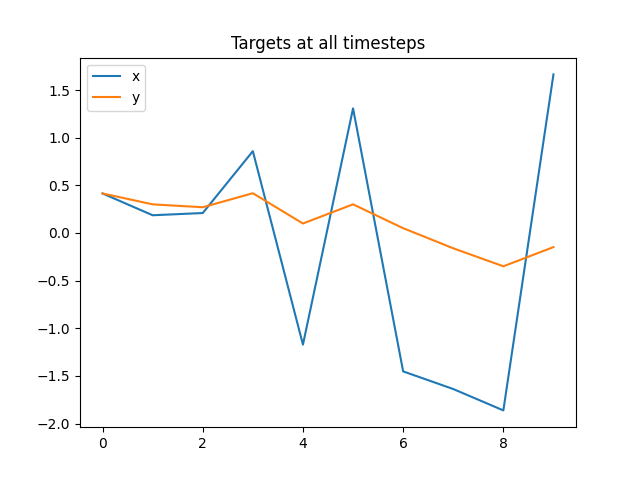

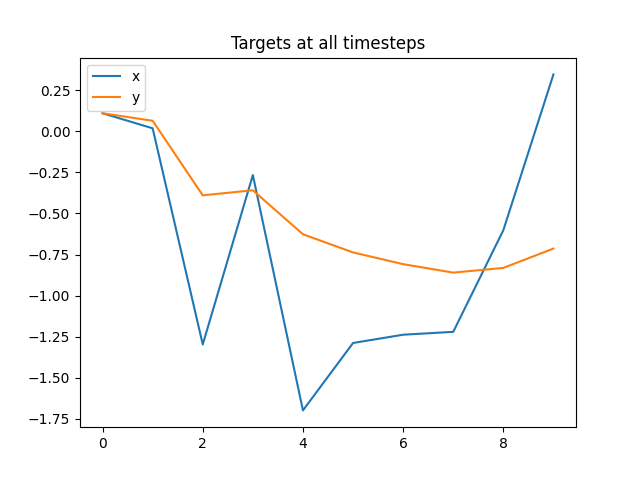

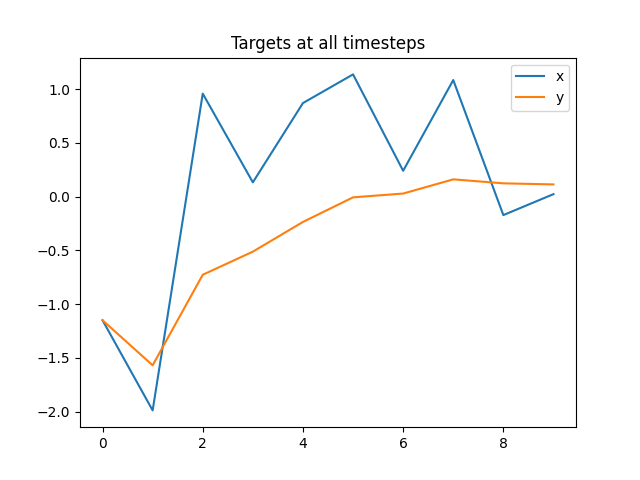

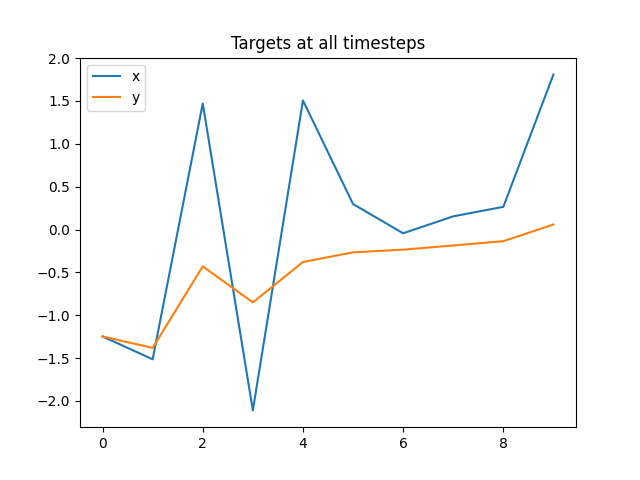

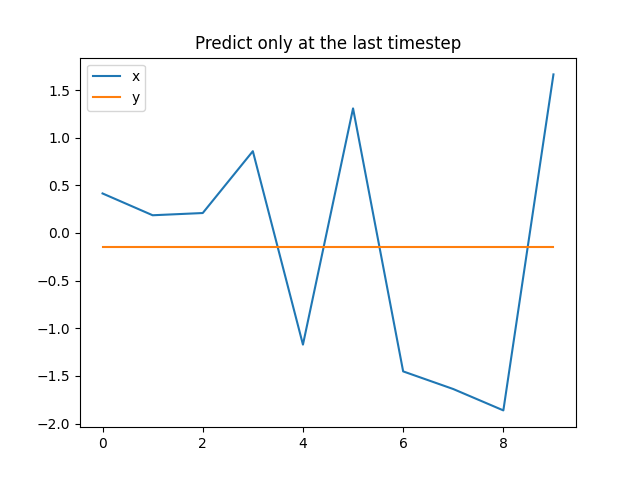

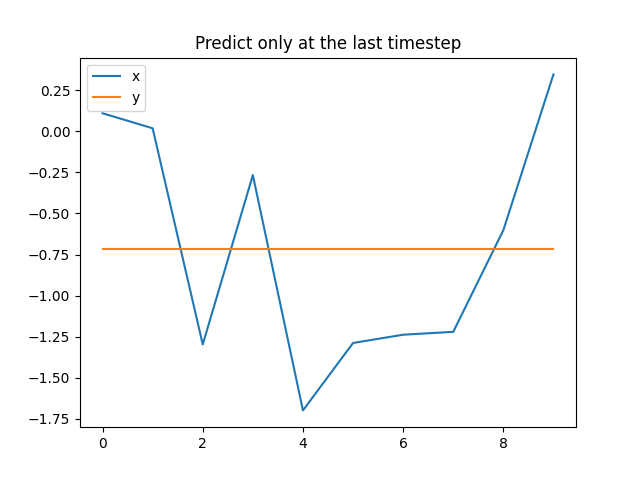

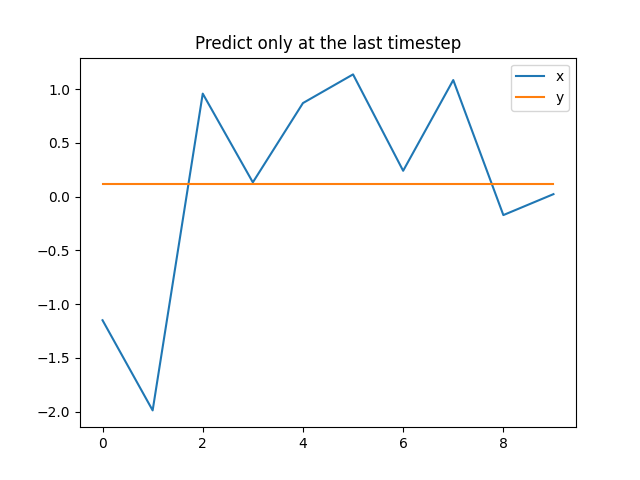

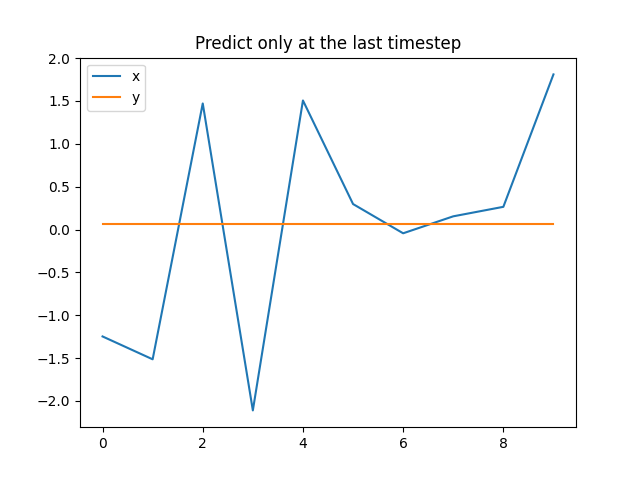

In [9]:
x, y = generate_batch(seq_len=10, batch_size=4)
for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(y[i, :, 0])
  ax1.legend(['x', 'y'])
  plt.title('Targets at all timesteps')
  plt.show()

for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(np.arange(10), [y[i, -1].item()] * 10)
  ax1.legend(['x', 'y'])
  plt.title('Predict only at the last timestep')
  plt.show()

## 1.C.ii Implement the loss function

In [10]:
def loss_fn(pred, y, last_timestep_only=False):
  """
  Inputs:
  - pred: model predictions of size (batch, seq_len, 1)
  - y: targets of size (batch, seq_len, 1)
  - last_timestep_only: boolean indicating whether to compute loss for all
    timesteps or only the lat

  Returns:
  - loss: scalar MSE loss between pred and true labels
  """
  ##############################################################################
  # TODO: implement the loss (HINT: look for pytorch's MSELoss function)       #
  ##############################################################################
    # Create MSE loss function
  mse_loss = th.nn.MSELoss()
  
  # Check if we should use only the last timestep
  if last_timestep_only:
    # Extract the last timestep from both predictions and targets
    pred_last = pred[:, -1]
    y_last = y[:, -1]
    loss = mse_loss(pred_last, y_last)
  else:
    # Compute loss over all timesteps
    loss = mse_loss(pred, y)
  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################
  return loss

### Tests
You should see errors < 1e-4

In [11]:
pred = th.FloatTensor([[.1, .2, .3], [.4, .5, .6]])
y = th.FloatTensor([[-1.1, -1.2, -1.3], [-1.4, -1.5, -1.6]])
loss_all = loss_fn(pred, y, last_timestep_only=False)
loss_last = loss_fn(pred, y, last_timestep_only=True)
assert loss_all.shape == loss_last.shape == th.Size([])
print(f'Max error loss_all: {th.abs(loss_all - th.tensor(3.0067)).item()}')
print(f'Max error loss_last: {th.abs(loss_last - th.tensor(3.7)).item()}')

Max error loss_all: 3.314018249511719e-05
Max error loss_last: 2.384185791015625e-07


# 1.D: Analyzing RNN Gradients

You do not need to understand the details of the GradientVisualizer class in order to complete this problem.

In [12]:
def biggest_eig_magnitude(matrix):
  """
  Inputs: a square matrix
  Returns: the scalar magnitude of the largest eigenvalue
  """
  h, w = matrix.shape
  assert h == w, f'Matrix has shape {matrix.shape}, but eigenvalues can only be computed for square matrices'
  eigs = th.linalg.eigvals(matrix)
  eig_magnitude = eigs.abs()
  eigs_sorted = sorted([i.item() for i in eig_magnitude], reverse=True)
  first_eig_magnitude = eigs_sorted[0]
  return first_eig_magnitude
  
class GradientVisualizer:

  def __init__(self, rnn, last_timestep_only):
    """
    Inputs:
    - rnn: rnn module
    - last_timestep_only: boolean indicating whether to compute loss for all
      timesteps or only the lat

    Returns:
    - loss: scalar MSE loss between pred and true labels
    """

    self.rnn = rnn
    self.last_timestep_only = last_timestep_only
    self.model = RecurrentRegressionModel(rnn)
    self.original_weights = copy.deepcopy(rnn.state_dict())

    # Generate a single batch to be used repeatedly
    self.x, self.y = generate_batch(seq_len=10)
    print(f'Data point: x={np.round(self.x[0, :, 0].detach().cpu().numpy(), 2)}, y={np.round(self.y.squeeze().detach().cpu().numpy(), 2)}')

  def plot_visuals(self):
    """ Generate plots which will be updated in realtime."""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('RNN Outputs')
    ax1.set_xlabel('Unroll Timestep')
    ax1.set_ylabel('Hidden State Norm')
    ax1.set_ylim(-1, 5)
    plt_1 = ax1.plot(np.arange(1, 11), np.zeros(10) + 1)  # placeholder vals
    plt_1 = plt_1[0]

    ax2.set_title('Gradients')
    ax2.set_xlabel('Unroll Timestep')
    ax2.set_ylabel('RNN dLoss/d a_t Gradient Magitude')
    ax2.set_ylim( (10**-6,1e5) )
    ax2.set_yscale('log')
    # X-axis labels are reversed since the gradient flow is from later layers to earlier layers
    ax2.set_xticks(np.arange(10), np.arange(10, 0, -1))
    plt_2 = ax2.plot(np.arange(10), np.arange(10) + 1)  # placeholder vals
    plt_2 = plt_2[0]
    self.fig = fig
    self.plots = [plt_1, plt_2]
    return plt_1, plt_2, fig

  # Main update function for interactive plot
  def update_plots(self, weight_val=0, bias_val=0):
    # Scale the original RNN weights by a constant
    w_dict = copy.deepcopy(self.original_weights)
    ##############################################################################
    # TODO: Scale all W matrixes by weight_val, and all bias matrices by bias_val#
    # If you're using PyTorch nn.Linear layers, you don't need to modify the code#
    # provided, but if you're using custom layers, modify this block.            #
    ##############################################################################
    # Scale weight matrices by weight_val
    if 'Wxh' in w_dict:
      w_dict['Wxh'] *= weight_val
    if 'Whh' in w_dict:
      w_dict['Whh'] *= weight_val
    
    # Scale bias matrices by bias_val
    if 'bh' in w_dict:
      w_dict['bh'] *= bias_val
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    self.rnn.load_state_dict(w_dict)

    # Don't compute for LSTMs, which don't have behavior dependent on a single eigenvalue
    if isinstance(self.rnn, RNNLayer):
      ##############################################################################
      # TODO: Set W = the weight which most affects exploding/vanishing gradients  #
      # Hint: Call module.weight or module.bias on the module you want to use      #
      # If you used a single Linear layer, slice a square matrix from it.          #
      ##############################################################################
      W = self.rnn.Whh
      ##############################################################################
      #                               END OF YOUR CODE                             #
      ##############################################################################
      biggest_eig = biggest_eig_magnitude(W)
      print(f' Biggest eigenvalue magnitude: {biggest_eig:.3}')

    # Run model
    pred, h = self.model(self.x)
    loss = loss_fn(pred, self.y, self.last_timestep_only)
    n_steps = len(h[0])

    plt_1, plt_2 = self.plots

    # Plot the hidden state magnitude
    max_h = th.linalg.norm(h[0], dim=-1).detach().cpu().numpy()
    print('Max H', ' '.join([f'{num:.3}' for num in max_h]))
    plt_1.set_data(np.arange(1, n_steps + 1), np.array(max_h))
    # Compute the gradient for the loss wrt the stored hidden states
    # Gradients are plotted backward since we go from later layers to earlier
    grads = [th.linalg.norm(num).item() for num in th.autograd.grad(loss, self.rnn.h_list)][::-1]
    print('gradients d Loss/d h_t', ' '.join([f'{num:.3}' for num in grads]))
    # Add 1e-6 since it throws an error for gradients near 0
    plt_2.set_data(np.arange(n_steps), np.array(grads) + 1e-6)
    self.fig.canvas.draw_idle()

  def create_visualization(self):
    # Include sliders for relevant quantities
    self.plot_visuals()
    ip = interactive(self.update_plots, 
                    weight_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="weight_scale", layout=Layout(width='100%')),
                    bias_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="bias_scale", layout=Layout(width='100%')),
                    )
    return ip

Adjust the sliders rescale the weight and bias parameters in the RNN. Observe the effect on exploding and vanishing gradients.

Parameters to try varying:
*   nonlinearity
*   last_target_only 



Data point: x=[ 0.37  0.69  0.3   0.17  1.6  -0.4  -0.57 -0.83  0.47 -0.8 ], y=[0.37 0.53 0.45 0.38 0.63 0.46 0.31 0.17 0.2  0.1 ]


interactive(children=(FloatSlider(value=0.0, description='weight_scale', layout=Layout(width='100%'), max=5.0,…

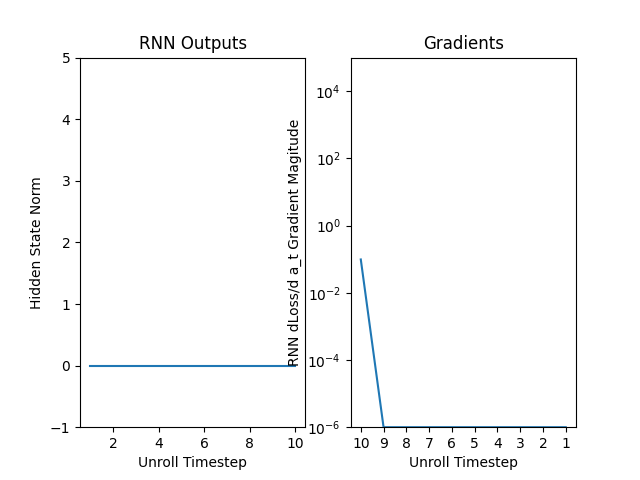

In [13]:
hidden_size = 16
nonlinearity = lambda x: x  # options include lambda x: x (no nonlinearity), nn.functional.relu, and th.tanh
last_target_only = True
rnn = RNNLayer(1, hidden_size, nonlinearity=nonlinearity)
gv = GradientVisualizer(rnn, last_target_only)
gv.create_visualization()

# If for some reason the slider doesn't work for you, try calling gv.update_plots
# with various values for weight and bias

# Problem 1.K: Making a multi-layer RNN

## 1.K.i: Implementing multi-layer models

In [14]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    """
    Initialize a multilayer RNN
    
    Inputs:
    - input_size: Data input feature dimension
    - hidden_size: hidden state size (also the output feature dimension)
    - num_layers: number of layers
    """
    super().__init__()
    assert num_layers >= 1
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    ##############################################################################
    # TODO: Initialize any parameters your class needs.                          #
    # Consider using nn.ModuleList or nn.ModuleDict.                             #
    ##############################################################################
        # Create a list of RNN layers using nn.ModuleList
    self.layers = nn.ModuleList()
    
    # The first layer has input_size as its input dimension
    self.layers.append(RNNLayer(input_size, hidden_size))
    
    # Add additional layers with hidden_size as both input and output dimension
    for _ in range(1, num_layers):
        self.layers.append(RNNLayer(hidden_size, hidden_size))
    
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def forward(self, x):
    """
    Multilayer RNN forward pass
    
    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - last_layer_h: tensor of size (B, seq_len, hidden_size) containing the
             outputs produced for each timestep from the last layer
    - last_step_h: all hidden states from the last step (num_layers, B, hidden_size)
    """
    ##############################################################################
    # TODO: Implement the RNN forward step                                       #
    ##############################################################################
        # Get batch size and sequence length
    B, seq_len, _ = x.shape
    
    # Initialize list to store the hidden states from the last step of each layer
    last_step_hidden = []
    
    # Current input to the first layer is the input x
    current_input = x
    
    # Process through each layer
    for layer_idx, layer in enumerate(self.layers):
        # Forward pass through the current layer
        all_h, last_h = layer(current_input)
        
        # Store the last hidden state of this layer
        last_step_hidden.append(last_h)
        
        # The output of this layer becomes the input to the next layer
        current_input = all_h
    
    # Set last_layer_h to the all_h from the final layer
    last_layer_h = all_h
    
    # Stack the last step hidden states across layers to get (num_layers, B, hidden_size)
    last_step_h = th.stack(last_step_hidden, dim=0)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return last_layer_h, last_step_h

### Test Cases

In [15]:
rnn = RNN(2, 3, 1)
rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_all_h = th.FloatTensor([[[-0.1244, -0.1244, -0.1244],
         [-0.1073, -0.1073, -0.1073],
         [-0.1320, -0.1320, -0.1320],
         [-0.1444, -0.1444, -0.1444]],

        [[ 0.0599,  0.0599,  0.0599],
         [ 0.1509,  0.1509,  0.1509],
         [ 0.2305,  0.2305,  0.2305],
         [-0.0840, -0.0840, -0.0840]]])
expected_last_h = th.FloatTensor([[[-0.1444, -0.1444, -0.1444],
         [-0.0840, -0.0840, -0.0840]]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert last_h.shape == expected_last_h.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_last_h - last_h)).item()}')

rnn = RNN(2, 3, 2)
rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_all_h = th.FloatTensor([[[-0.0626, -0.0626, -0.0626],
         [-0.0490, -0.0490, -0.0490],
         [-0.0457, -0.0457, -0.0457],
         [-0.0430, -0.0430, -0.0430]],
        [[-0.1174, -0.1174, -0.1174],
         [-0.1096, -0.1096, -0.1096],
         [-0.1354, -0.1354, -0.1354],
         [-0.0342, -0.0342, -0.0342]]])
expected_last_h = th.FloatTensor([[[-0.1444, -0.1444, -0.1444],
         [-0.0840, -0.0840, -0.0840]],
        [[-0.0430, -0.0430, -0.0430],
         [-0.0342, -0.0342, -0.0342]]])
all_h, last_h = rnn(data)
assert all_h.shape == (2, 4, 3)
assert last_h.shape == (2, 2, 3)
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_last_h - last_h)).item()}')



Max error all_h: 4.699826240539551e-05
Max error last_h: 4.1253864765167236e-05
Max error all_h: 4.3511390686035156e-05
Max error last_h: 4.1253864765167236e-05


## 1.K.ii: Training your model

In [16]:
def train(model, optimizer, num_batches, last_timestep_only, seq_len=10, batch_size=32):
  model
  model.train()

  losses = []
  from tqdm import tqdm
  t = tqdm(range(0, num_batches))
  for i in t:
      data, labels = generate_batch(seq_len=seq_len, batch_size=batch_size)
      pred, h = model(data)
      loss = loss_fn(pred, labels, last_timestep_only)
      losses.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if i % 100 == 0:
          t.set_description(f"Batch: {i} Loss: {np.mean(losses[-10:])}")
  return losses

In [17]:
def train_all(hidden_size, lr, num_batches, last_timestep_only):
  input_size = 1
  rnn_1_layer = RecurrentRegressionModel(RNN(input_size, hidden_size, 1))
  rnn_2_layer = RecurrentRegressionModel(RNN(input_size, hidden_size, 2))
  models = [rnn_1_layer, rnn_2_layer]
  model_names = ['rnn_1_layer', 'rnn_2_layer']

  losses = []
  for model in models:
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss = train(model, optimizer, num_batches, last_timestep_only)
    losses.append(loss)

  # visualize the results
  fig, ax1 = plt.subplots(1)
  for loss in losses:
    ax1.plot(loss)
  ax1.legend(model_names)
  plt.show()

  batch_size = 4
  x, y = generate_batch(seq_len=10, batch_size=batch_size)
  preds_list = [model(x)[0] for model in models]
  for i in range(batch_size):
    fig, ax1 = plt.subplots(1)
    ax1.plot(x[i, :, 0])
    if last_timestep_only:
      ax1.plot(np.arange(10), [y[i, -1].item()] * 10, 'bo')
    else:
      ax1.plot(y[i, :, 0], 'bo')
    for pred in preds_list:
      if last_timestep_only:
        ax1.plot(np.arange(10), [pred[i, -1, 0].detach().cpu().numpy()] * 10)
      else:
        ax1.plot(pred[i, :, 0].detach().cpu().numpy())
    ax1.legend(['x', 'y'] + model_names)
    plt.show()
  return models, losses

Batch: 4900 Loss: 0.13836785405874252: 100%|██████████| 5000/5000 [00:11<00:00, 447.26it/s]


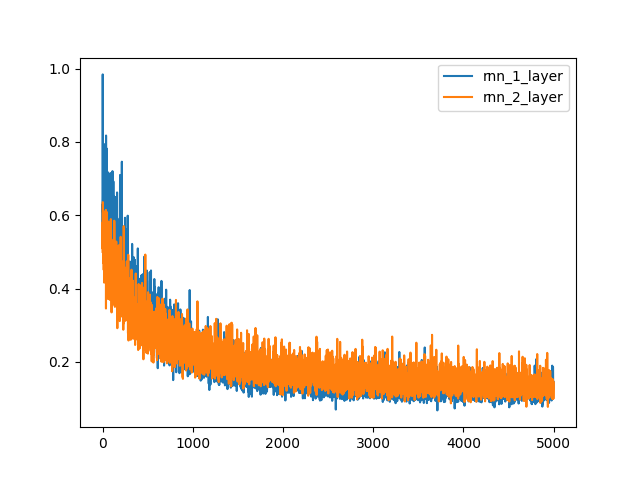

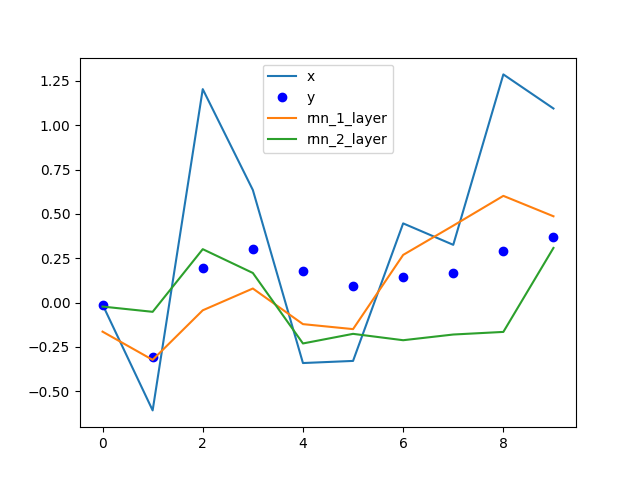

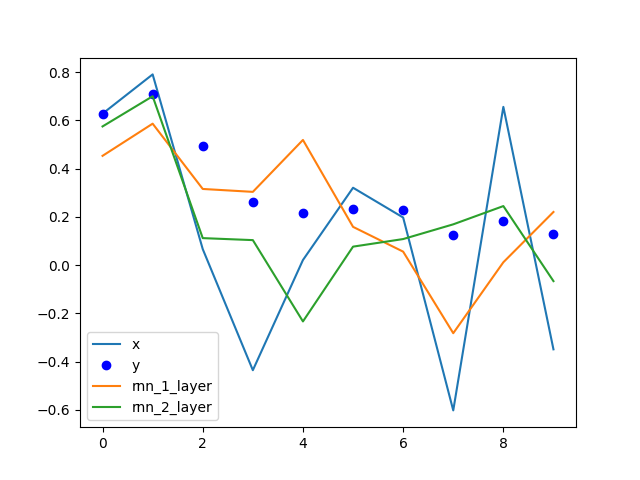

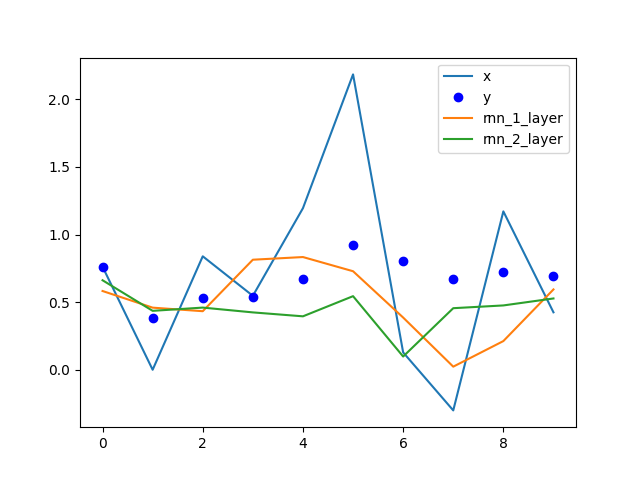

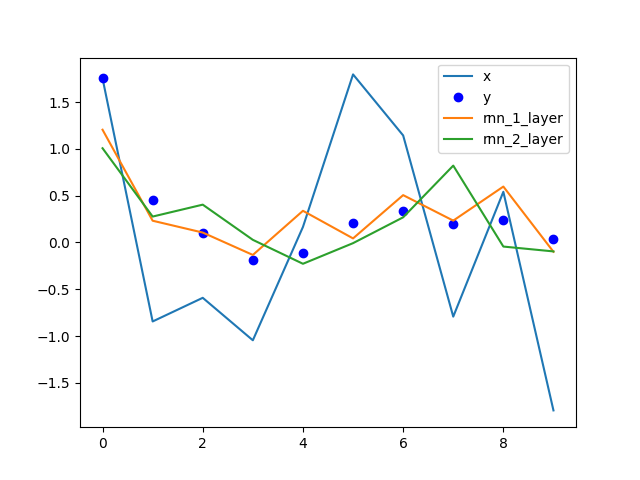

Batch: 4900 Loss: 0.10178238525986671: 100%|██████████| 5000/5000 [00:11<00:00, 437.22it/s]


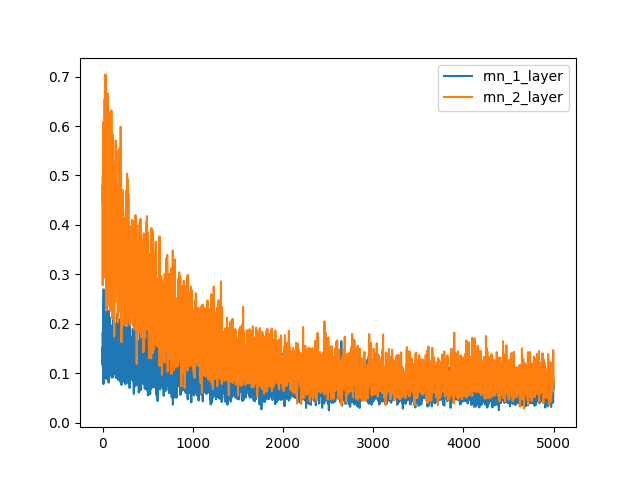

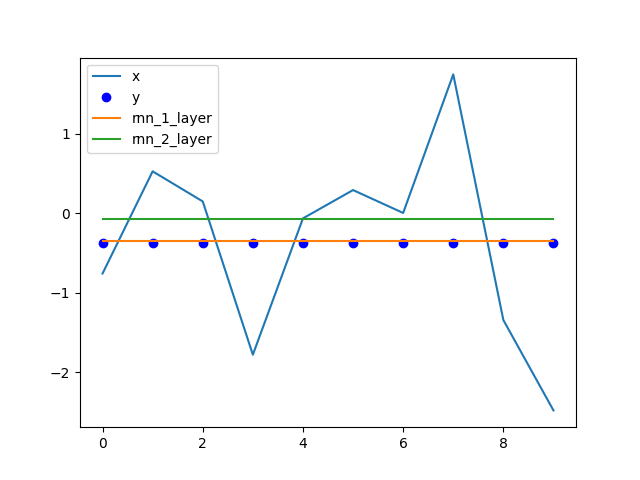

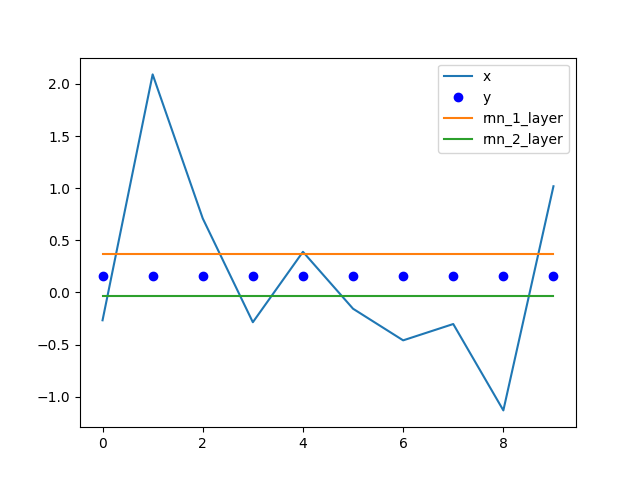

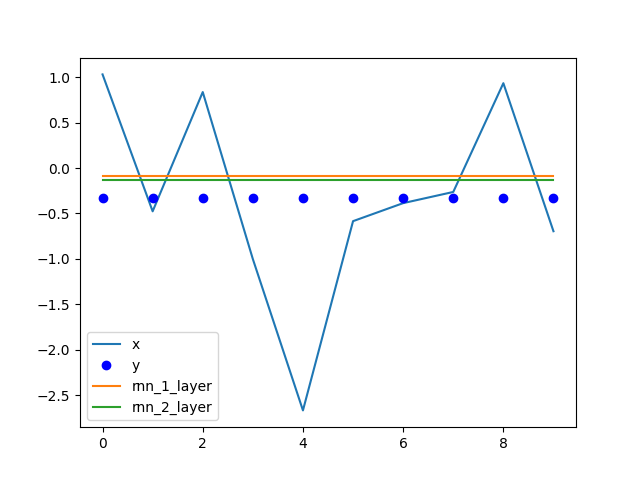

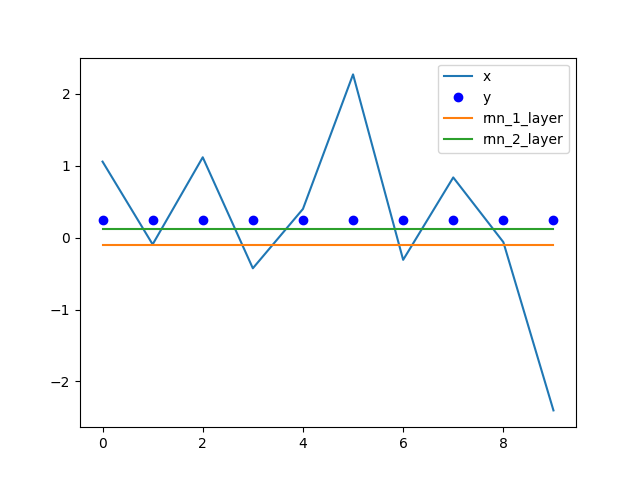

In [18]:
hidden_size = 32
lr = 1e-4
num_batches = 5000
last_timestep_only = False

th.manual_seed(0)
predict_all_models, predict_all_losses = train_all(hidden_size, lr, num_batches, last_timestep_only)
last_timestep_only = True
predict_one_models, predict_one_losses = train_all(hidden_size, lr, num_batches, last_timestep_only)